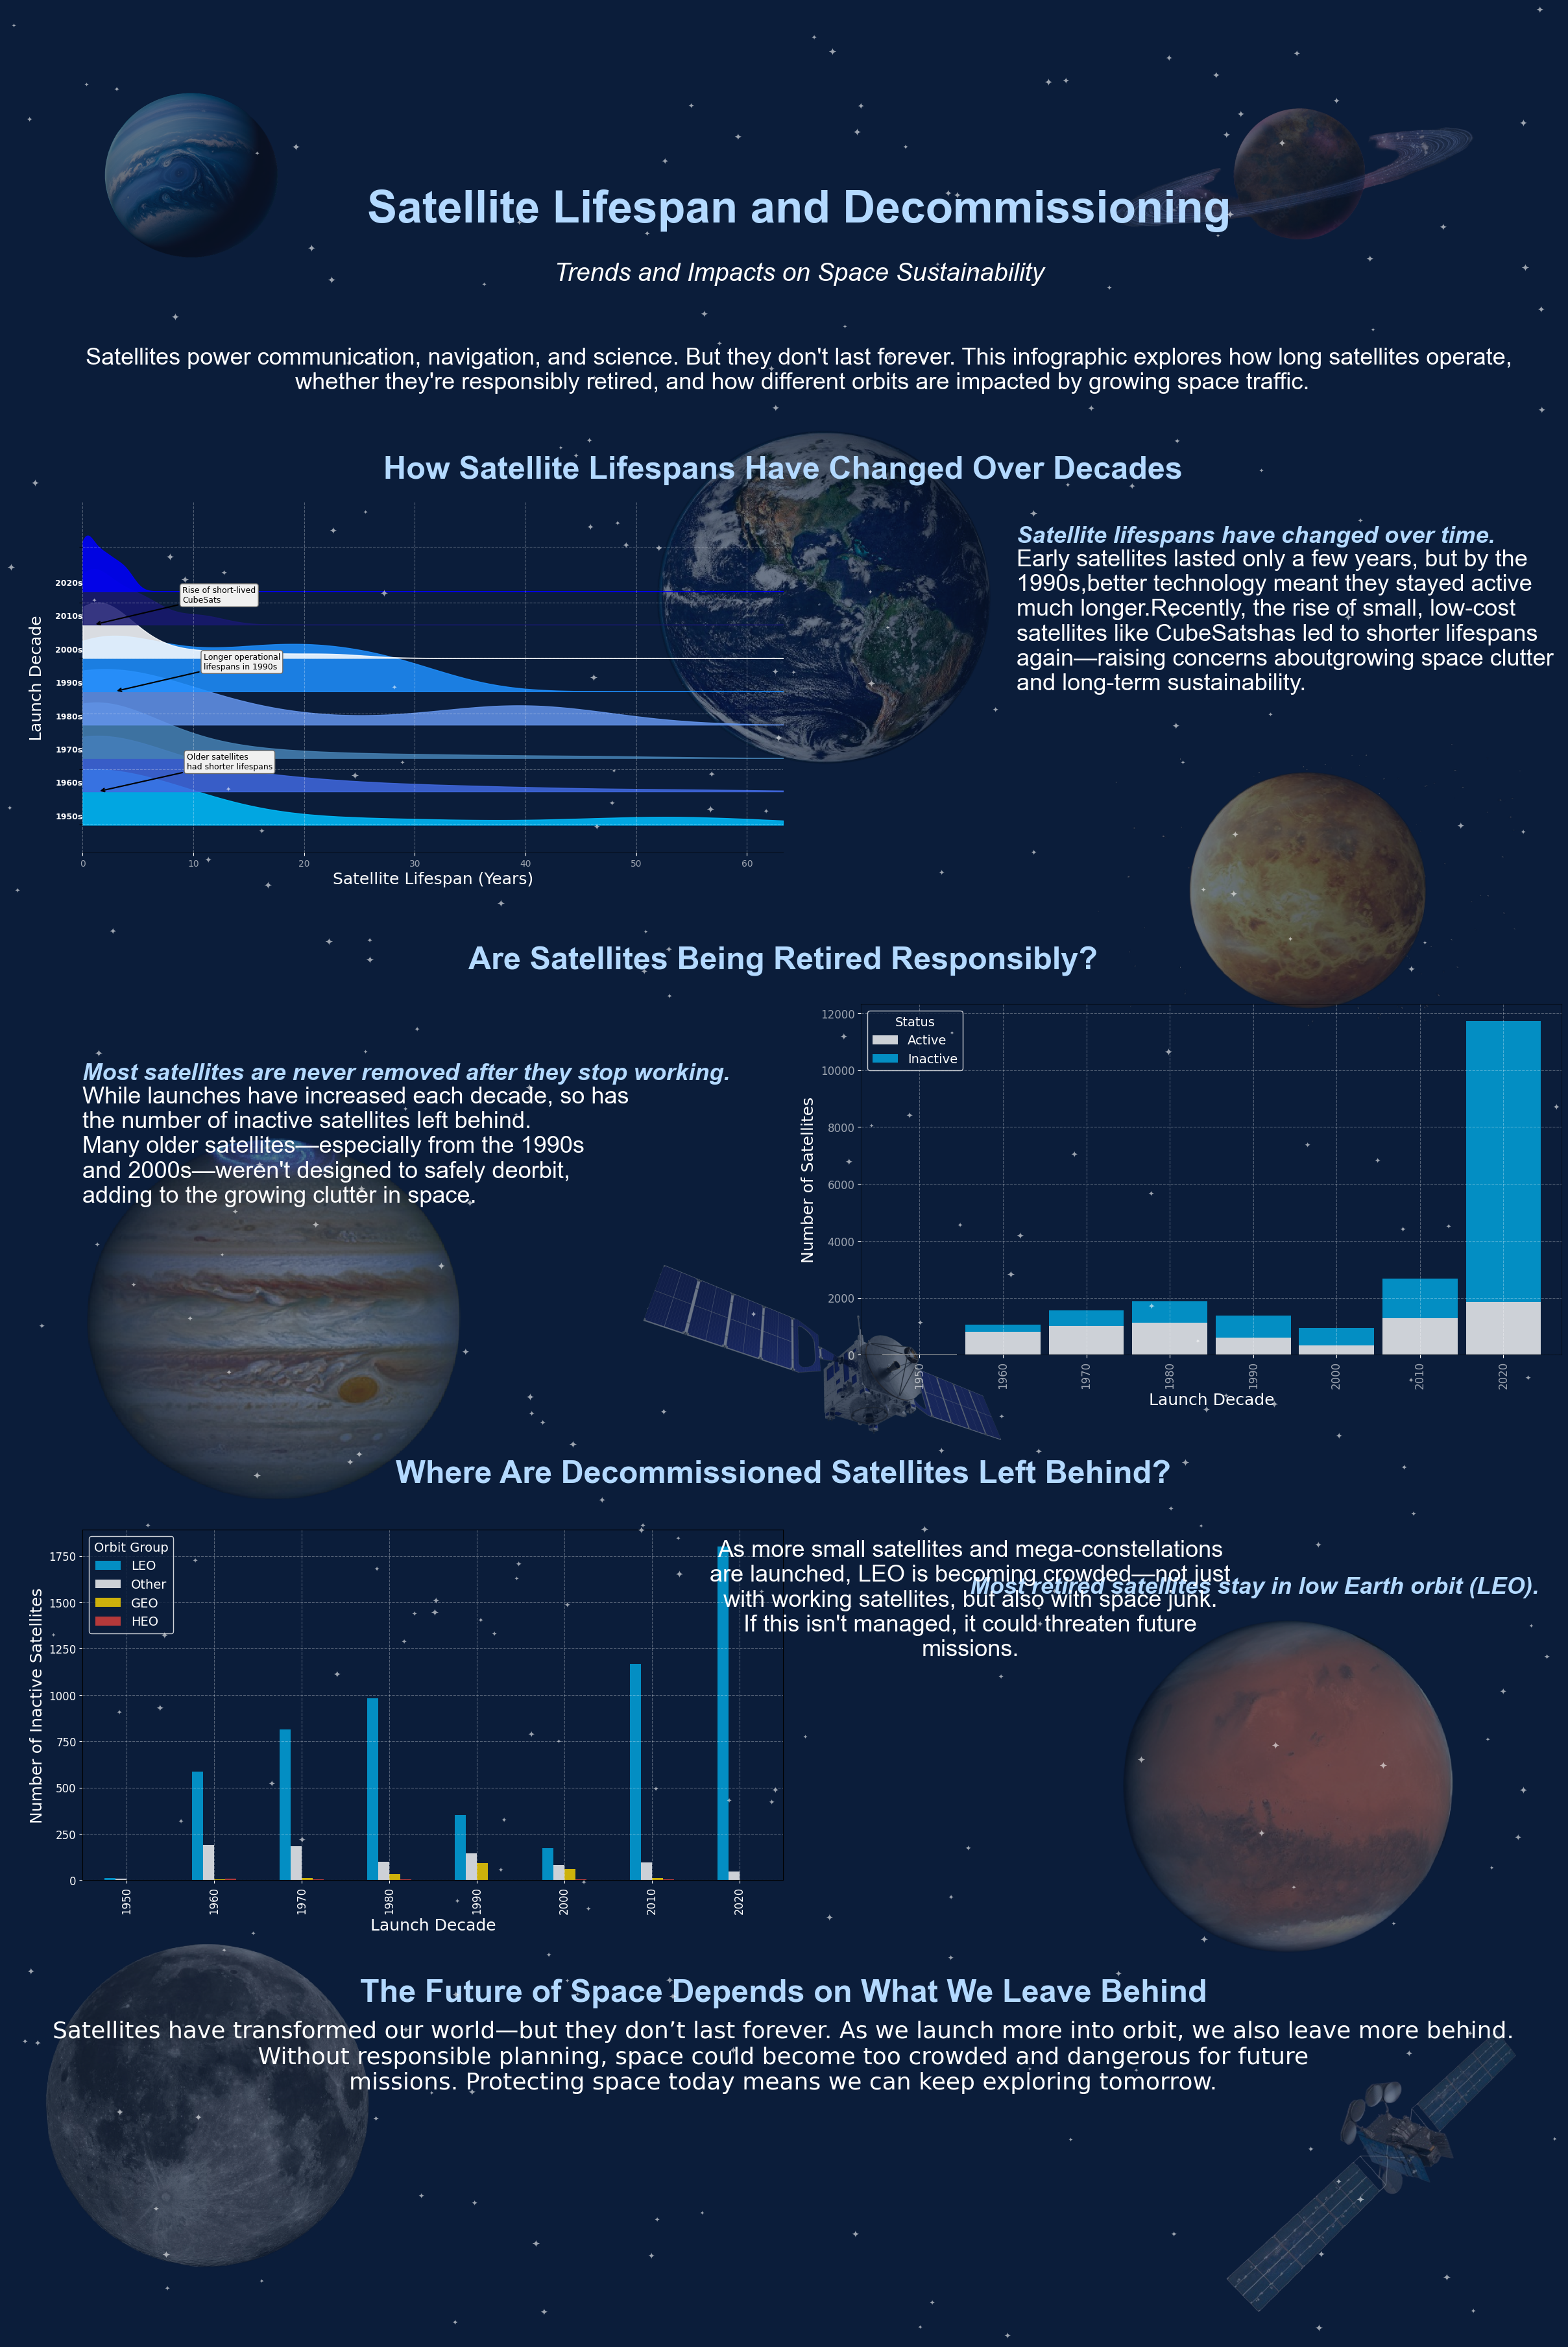

In [ ]:
"""
COMP 4304 Project
Abdul Sattar Sanny(202173944)
Abrar Faiyaz(201940046)
"""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import matplotlib.image as mpimg
import matplotlib.font_manager as fm

from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
from textwrap import fill


# Load and prepare data
satcat_df = pd.read_csv("satcat.tsv", sep="\t", low_memory=False)


def parse_vague_date_str(s):
    if pd.isna(s) or s.strip() in ("?", ""):
        return pd.NaT
    s = s.strip().rstrip("?s")
    
    # Common vague date formats
    for fmt in ["%Y %b %d %H%M", "%Y %b %d", "%Y %b", "%Y"]:
        try:
            return pd.to_datetime(s, format=fmt)
        except Exception:
            continue
    return pd.NaT

# Apply to columns
satcat_df["LDate"] = satcat_df["LDate"].apply(parse_vague_date_str)
satcat_df["DDate"] = satcat_df["DDate"].apply(parse_vague_date_str)


df = satcat_df[satcat_df["Type"].str.startswith("P", na=False)].copy()
df["DecayOrNow"] = df["DDate"].fillna(pd.Timestamp.now())
df["Lifespan_Years"] = (df["DecayOrNow"] - df["LDate"]).dt.total_seconds() / (365.25 * 24 * 3600)
df = df[(df["Lifespan_Years"] >= 0) & (df["Lifespan_Years"] <= 100)]

df["Launch_Year"] = df["LDate"].dt.year
df["Launch_Decade"] = (df["Launch_Year"] // 10) * 10
df["IsActive"] = df["DDate"].isna()

# Plot 1 data
satcat_df['LIFESPAN_YEARS'] = (satcat_df['DDate'] - satcat_df['LDate']).dt.days / 365.25
satcat_df = satcat_df[satcat_df['LIFESPAN_YEARS'] > 0]  # Remove invalid/negative lifespans

satcat_df['LAUNCH_DECADE'] = (satcat_df['LDate'].dt.year // 10) * 10
decade_order = sorted(satcat_df['LAUNCH_DECADE'].dropna().unique())

# Plot 2 data
status_by_decade = df.groupby(["Launch_Decade", "IsActive"]).size().unstack(fill_value=0)

# Plot 3 data
inactive_df = df[~df["IsActive"]].copy()
inactive_df["Launch_Decade"] = (inactive_df["LDate"].dt.year // 10) * 10
inactive_df = inactive_df.dropna(subset=["OpOrbit", "Launch_Decade"])

orbit_map = {
    "LLEO/S": "LEO", "LLEO/I": "LEO", "LEO/S": "LEO", "LEO/I": "LEO", "LEO": "LEO", "SSO": "LEO",
    "GEO": "GEO", "GEO/I": "GEO", "GEO/S": "GEO",
    "MEO": "MEO", "MEO/I": "MEO",
    "HEO": "HEO", "HEO/I": "HEO"
}
inactive_df["Orbit_Group"] = inactive_df["OpOrbit"].map(orbit_map).fillna("Other")
orbit_grouped = inactive_df.groupby(["Launch_Decade", "Orbit_Group"]).size().unstack(fill_value=0)
top_orbit_groups = orbit_grouped.sum().sort_values(ascending=False).head(4).index
orbit_grouped_top = orbit_grouped[top_orbit_groups]

# Build infographic
fig = plt.figure(figsize=(24, 36))
fig.patch.set_facecolor("#0b1d3a")
label_color = "white"

# Background styling
n_stars = 300
star_x = np.random.rand(n_stars)
star_y = np.random.rand(n_stars)
for sx, sy in zip(star_x, star_y):
    fig.text(sx, sy, "✦", fontsize=np.random.randint(6, 12), color="white", alpha=0.6,zorder=0)

# Load images
"""
To load the images here on the infographic, copy the .png files from
the folder "assets" and paste it where this .ipynb file is. In other words, 
keep this jupyter notebook file and the images from "assets" folder in the same folder.
"""
moon_img = mpimg.imread("real_moon.png")
planet_img = mpimg.imread("real_planet.png")
saturn_img = mpimg.imread("real_saturn.png")
neptune_img = mpimg.imread("real_neptune.png")
venus_img = mpimg.imread("real_venus.png") 
earth_img=mpimg.imread("real_earth.png")
jupiter_img=mpimg.imread("real_jupiter.png")
sat_img=mpimg.imread("sat.png")
sat2_img=mpimg.imread("sat2.png")

scale = 0.25
h, w = neptune_img.shape[:2]
neptune_small = neptune_img[::int(1/scale), ::int(1/scale)]

# Render background images via imshow (layered properly)

sat_ax = fig.add_axes([0.75, -0.05, 0.25, 0.25], zorder=0)
sat_ax.imshow(sat_img, alpha=0.4)
sat_ax.axis("off")

sat2_ax = fig.add_axes([0.40, 0.30, 0.25, 0.25], zorder=0)
sat2_ax.imshow(sat2_img, alpha=0.4)
sat2_ax.axis("off")

earth_ax = fig.add_axes([0.40, 0.66, 0.25, 0.18], zorder=0)
earth_ax.imshow(earth_img, alpha=0.4)
earth_ax.axis("off")

jupiter_ax = fig.add_axes([0.02, 0.35, 0.30, 0.18], zorder=0)
jupiter_ax.set_facecolor("#0b1d3a")
jupiter_ax.imshow(jupiter_img, alpha=0.4, interpolation='none')
jupiter_ax.axis("off")

venus_ax = fig.add_axes([0.70, 0.50, 0.28, 0.25], zorder=0)  # NEW planet placement
venus_ax.imshow(venus_img, alpha=0.4)
venus_ax.axis("off")


moon_ax = fig.add_axes([0.005, 0.005, 0.25, 0.20], zorder=0)
moon_ax.imshow(moon_img, alpha=0.4)
moon_ax.axis("off")

planet_ax = fig.add_axes([0.70, 0.15, 0.25, 0.18], zorder=0)
planet_ax.imshow(planet_img, alpha=0.4)
planet_ax.axis("off")

saturn_ax = fig.add_axes([0.70, 0.87, 0.25, 0.12], zorder=0)
saturn_ax.imshow(saturn_img, alpha=0.4)
saturn_ax.axis("off")

neptune_ax = fig.add_axes([0.02, 0.87, 0.20, 0.12], zorder=0)
neptune_ax.imshow(neptune_small, alpha=0.4)
neptune_ax.axis("off")


# Title section
ax0 = fig.add_axes([0.05, 0.82, 0.92, 0.1])
ax0.axis("off")
ax0.text(0.5, 0.9, "Satellite Lifespan and Decommissioning",fontfamily = "Arial", fontsize=50, weight='bold', ha='center', color="#b3d9ff")
ax0.text(0.5, 0.65, "Trends and Impacts on Space Sustainability",fontfamily = "Arial", fontsize=28, style='italic', ha='center', color=label_color)
ax0.text(0.5, 0.2,
         "Satellites power communication, navigation, and science. But they don't last forever. "
         "This infographic explores how long satellites operate,\n whether they're responsibly retired, "
         "and how different orbits are impacted by growing space traffic.",
         fontfamily = "Arial", fontsize=26, ha='center', wrap=True, color=label_color)

# Custom space-themed colors (converted to matplotlib RGBA tuples)
colors = [
    (0/255, 191/255, 255/255, 0.7),   # Deep Sky Blue
    (65/255, 105/255, 225/255, 0.7),  # Royal Blue
    (70/255, 130/255, 180/255, 0.7),  # Steel Blue
    (100/255, 149/255, 237/255, 0.7), # Cornflower Blue
    (30/255, 144/255, 255/255, 0.7),  # Dodger Blue
    (255/255, 255/255, 255/255, 0.8), # White-ish
    (25/255, 25/255, 112/255, 0.7),   # Midnight Blue
    (0/255, 0/255, 255/255, 0.7),     # Blue
    (135/255, 206/255, 250/255, 0.7), # Light Sky Blue
    (0/255, 0/255, 205/255, 0.7)      # Medium Blue
]

# Limit colors to number of decades
colors = colors[:len(decade_order)]

# Create the axis
ax1 = fig.add_axes([0.05, 0.64, 0.45, 0.15])
ax1.set_facecolor("#0b1d3a")
x_grid = np.linspace(0, satcat_df['LIFESPAN_YEARS'].max(), 500)
overlap = 0.6


# Plot 1 - Lifespans by Decade
for i, (decade, color) in enumerate(zip(decade_order, colors)):
    data = satcat_df[satcat_df['LAUNCH_DECADE'] == decade]['LIFESPAN_YEARS']
    if len(data) < 2:
        continue

    kde = gaussian_kde(data, bw_method=0.5)
    y = kde(x_grid)
    y /= y.max()

    y_offset = i * overlap
    ax1.fill_between(x_grid, y + y_offset, y_offset, color=color, alpha=0.85)

    ax1.text(0, y_offset + 0.15, f"{decade}s", ha='right', va='center',
             fontsize=9, weight='bold', color='white')

    #Annotations on plot
    if decade == 1960:
        peak_x = x_grid[np.argmax(y)]
        ax1.annotate("Older satellites\nhad shorter lifespans",
                     xy=(peak_x, y_offset), xytext=(peak_x + 8, y_offset + 0.4),
                     arrowprops=dict(arrowstyle="->", color='black', lw=1.5),
                     fontsize=9, color="black",
                     bbox=dict(boxstyle="round,pad=0.3", fc="#f0f0f0", ec="dimgray", lw=1))
    elif decade == 1990:
        peak_x = x_grid[np.argmax(y)]
        ax1.annotate("Longer operational\nlifespans in 1990s",
                     xy=(peak_x, y_offset), xytext=(peak_x + 8, y_offset + 0.4),
                     arrowprops=dict(arrowstyle="->", color='black', lw=1.5),
                     fontsize=9, color="black",
                     bbox=dict(boxstyle="round,pad=0.3", fc="#f0f0f0", ec="dimgray", lw=1))
    elif decade == 2010:
        peak_x = x_grid[np.argmax(y)]
        ax1.annotate("Rise of short-lived\nCubeSats",
                     xy=(peak_x, y_offset), xytext=(peak_x + 8, y_offset + 0.4),
                     arrowprops=dict(arrowstyle="->", color='black', lw=1.5),
                     fontsize=9, color="black",
                     bbox=dict(boxstyle="round,pad=0.3", fc="#f0f0f0", ec="dimgray", lw=1))


# Plot 1 Text

fig.suptitle(
    "How Satellite Lifespans Have Changed Over Decades",
    fontweight= 'bold',
    fontsize=35,
    fontfamily="Arial",
    color="#b3d9ff",
    x=0.5,   # center horizontally (default)
    y=0.81,  # adjust vertical position as needed
    ha='center'
)
fig.text(
    0.65, 0.78,
    "Satellite lifespans have changed over time.",
    fontsize=26,
    fontfamily='Arial',
    fontweight = 'bold',
    fontstyle = 'italic',
    color='#b3d9ff',
    ha='left',
    va='top',
    zorder=1,
    wrap=True,
)
fig.text(
    0.65, 0.77,
    "Early satellites lasted only a few years, but by the 1990s,"
    "better technology meant they stayed active much longer."
    "Recently, the rise of small, low-cost satellites like CubeSats"
    "has led to shorter lifespans again—raising concerns about"
    "growing space clutter and long-term sustainability.",
    fontsize=26,
    fontfamily='Arial',
    color='white',
    ha='left',
    va='top',
    zorder=1,
    wrap=True,
)

# Final styling
ax1.patch.set_alpha(0)
ax1.set_xlim(0, x_grid.max())
ax1.set_ylim(-0.5, len(decade_order) * overlap + 1)
ax1.set_xlabel("Satellite Lifespan (Years)", fontsize=18, color=label_color)
ax1.set_ylabel("Launch Decade", fontsize=18, color=label_color, labelpad=35)
ax1.tick_params(axis='x', colors=label_color)
ax1.spines[['right', 'top', 'left']].set_visible(False)
ax1.grid(True, linestyle="--", alpha=0.3, color="white")
ax1.set_yticklabels([])  # No ticks on y-axis
for spine in ax1.spines.values(): #For blending plot elements with background
    spine.set_alpha(0.4)
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_alpha(0.6)


# Plot 2 - Status by Decade

ax2 = fig.add_axes([0.55, 0.425, 0.45, 0.15])
ax2.set_facecolor("#0b1d3a")

# Apply matching space-themed blue and white
status_colors = [
    (255/255, 255/255, 255/255, 0.8),  # White-ish for Active
    (0/255, 191/255, 255/255, 0.7)     # Deep Sky Blue for Inactive
]

status_by_decade.plot(kind="bar", stacked=True, color=status_colors, ax=ax2, width=0.9, legend=False)

#Plot 2 Text
fig.text(
    0.5, 0.60,
    "Are Satellites Being Retired Responsibly?",
    ha='center', va='top',
    fontsize=35,
    fontweight='bold',
    fontfamily='Arial',
    color='#b3d9ff'
)

fig.text(
    0.05, 0.55,
    "Most satellites are never removed after they stop working.",
    fontsize=26,
    fontfamily='Arial',
    fontweight='bold',
    fontstyle='italic',
    color='#b3d9ff',
    ha='left',
    va='top',
    wrap=True,
    clip_on=False,
)
# Create text with proper wrapping
text2 = (
    "While launches have increased each decade,"
    " so has the number of inactive satellites left behind. "
    "Many older satellites—especially from the 1990s"
    " and 2000s—weren't designed to safely deorbit, "
    "adding to the growing clutter in space."
)
# Wrap text into multiple lines with appropriate width
wrapped_text = fill(text2, width=50)
fig.text(
    0.05, 0.54,
    wrapped_text,
    fontsize=26,
    fontfamily='Arial',
    color='white',
    ha='left',
    va='top',
    wrap=True,
    clip_on=False,
)

ax2.patch.set_alpha(0)
ax2.set_xlabel("Launch Decade", fontsize=18, color=label_color)
ax2.set_ylabel("Number of Satellites", fontsize=18, color=label_color)
ax2.tick_params(labelsize=12, colors=label_color)
ax2.grid(True, linestyle="--", alpha=0.3, color="white")
for spine in ax2.spines.values(): #For blending plot elements with background
    spine.set_alpha(0.4)
for label in ax2.get_xticklabels() + ax2.get_yticklabels():
    label.set_alpha(0.6)

# Add legend and update title color
legend2 = ax2.legend(
    ["Active", "Inactive"],
    title="Status",
    loc='upper left',
    fontsize=14,
    title_fontsize=14,
    labelcolor=label_color,
    facecolor="#0b1d3a",
    edgecolor="white"
)
legend2.get_title().set_color("white")


# Plot 3 - Satellite Decommissioning

ax3 = fig.add_axes([0.05, 0.20, 0.45, 0.15])
ax3.set_facecolor("#0b1d3a")

# Apply space-style blue palette
orbit_colors = [
    (0/255, 191/255, 255/255, 0.7),    # Deep Sky Blue
    (255/255, 255/255, 255/255, 0.8),   # white-ish
    (255/255, 215/255, 0/255, 0.8),    # Yellow
    (255/255, 69/255, 58/255, 0.7)     # Red
]

orbit_grouped_top.plot(kind="bar", ax=ax3, color=orbit_colors)

#Plot 3 Text
fig.text(
    0.5, 0.38,
    "Where Are Decommissioned Satellites Left Behind?",
    ha='center', va='top',
    fontsize=35,
    fontweight='bold',
    fontfamily='Arial',
    color='#b3d9ff'
)
fig.text(
    0.62, 0.33,
    "Most retired satellites stay in low Earth orbit (LEO). ",
    fontsize=26,
    fontfamily='Arial',
    fontweight='bold',
    fontstyle='italic',
    color='#b3d9ff',
    ha='left',
    va='top',
    wrap=True,
    clip_on=False,
)
text3 = (
    "As more small satellites and mega-constellations are launched, "
    "LEO is becoming crowded—not just with working satellites, "
    "but also with space junk. If this isn't managed, "
    "it could threaten future missions."
)
# Wrap text into multiple lines with appropriate width
wrapped2_text = fill(text3, width=50)
fig.text(
    0.62, 0.32,
    wrapped2_text,
    fontsize=26,
    fontfamily='Arial',
    color='white',
    ha='left',
    va='top',
    wrap=True,
    clip_on=False,
)


ax3.patch.set_alpha(0)
ax3.set_xlabel("Launch Decade", fontsize=18, color=label_color)
ax3.set_ylabel("Number of Inactive Satellites", fontsize=18, color=label_color)
ax3.tick_params(labelsize=12, colors=label_color)
ax3.grid(True, linestyle="--", alpha=0.3, color="white")
for spine in ax2.spines.values():
    spine.set_alpha(0.4)
for label in ax2.get_xticklabels() + ax2.get_yticklabels():
    label.set_alpha(0.6)

legend = ax3.legend(
    title="Orbit Group",
    loc='upper left',
    fontsize=14,
    title_fontsize=14,
    labelcolor=label_color,
    facecolor="#0b1d3a",
    edgecolor="white"
)
legend.get_title().set_color("white")

# Conclusion
ax4 = fig.add_axes([0.05, 0.10, 0.9, 0.12])
ax4.axis("off")
ax4.text(0.5, 0.40, "The Future of Space Depends on What We Leave Behind",fontfamily="Arial", fontsize=35, weight='bold', ha='center', color="#b3d9ff")
ax4.text(0.5, 0.10,
         "Satellites have transformed our world—but they don’t last forever. "
         "As we launch more into orbit, we also leave more behind.\n "
         "Without responsible planning, space could become too crowded and dangerous for future \nmissions. "
         "Protecting space today means we can keep exploring tomorrow.",
         fontsize=26, ha='center', wrap=True, color=label_color)

plt.savefig("infographic.pdf", dpi=100, bbox_inches='tight', facecolor=fig.get_facecolor())

